
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None

First 5 rows:
  Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011          

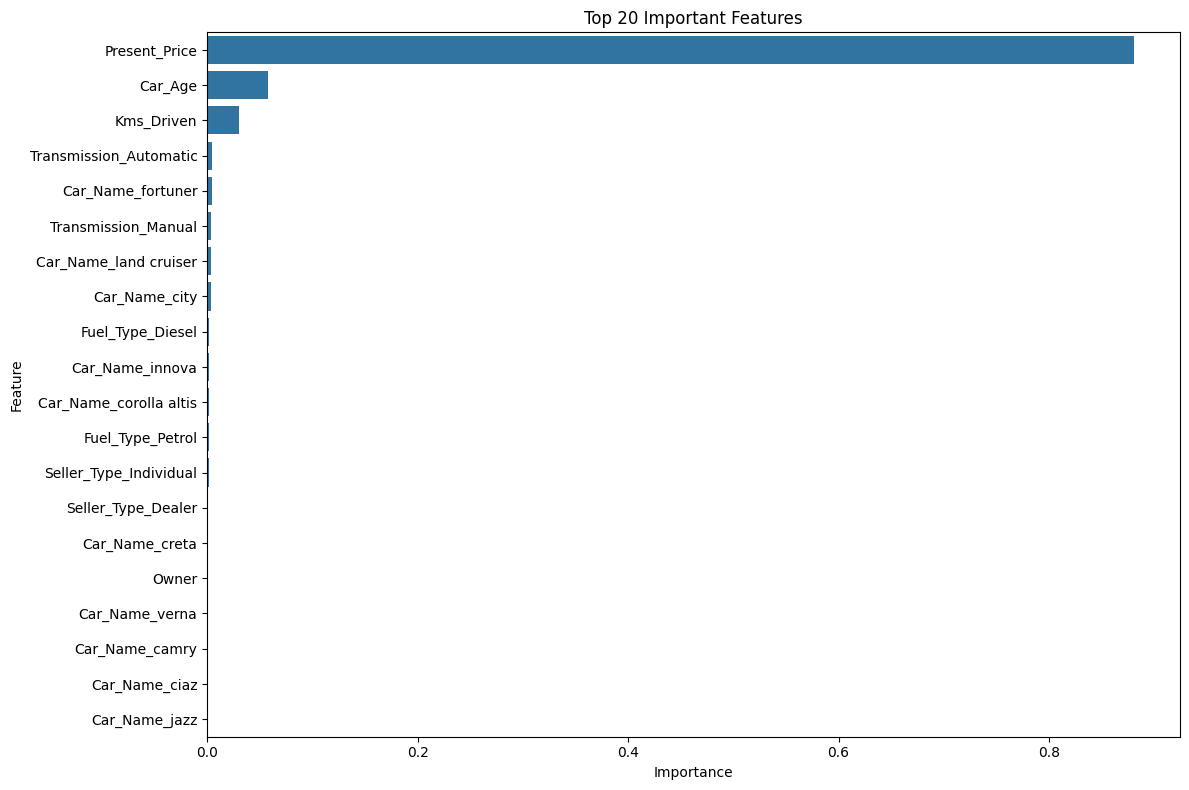


Model saved as 'car_price_model.joblib'

Example Prediction: ₹9.79 lakhs


In [ ]:
# car_price_prediction.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from flask import Flask, request, jsonify

# 1. Data Loading and Exploration
def load_and_explore_data(filepath):
    """Load the dataset and perform initial exploration"""
    df = pd.read_csv(filepath)

    print("\nDataset Info:")
    print(df.info())

    print("\nFirst 5 rows:")
    print(df.head())

    print("\nStatistical Summary:")
    print(df.describe())

    print("\nMissing Values:")
    print(df.isnull().sum())

    return df

# 2. Data Preprocessing and Feature Engineering
def preprocess_data(df):
    """Clean and preprocess the data"""
    # Create car age feature
    current_year = pd.Timestamp.now().year
    df['Car_Age'] = current_year - df['Year']

    # Drop original year column
    df.drop('Year', axis=1, inplace=True)

    # Handle categorical columns
    categorical_cols = ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']
    for col in categorical_cols:
        print(f"\nUnique values in {col}:")
        print(df[col].value_counts())

    return df

# 3. Model Training
def train_model(df):
    """Train the car price prediction model"""
    # Define features and target
    X = df.drop('Selling_Price', axis=1)
    y = df['Selling_Price']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Define global for feature usage
    global numeric_features, categorical_features
    numeric_features = ['Present_Price', 'Kms_Driven', 'Owner', 'Car_Age']
    categorical_features = ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=150,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        ))
    ])

    # Train model
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)

    print("\nModel Evaluation:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

    return model

# 4. Feature Importance Visualization
def plot_feature_importance(model):
    """Visualize feature importance"""
    # Get feature names
    preprocessor = model.named_steps['preprocessor']
    cat_encoder = preprocessor.named_transformers_['cat']
    cat_features = cat_encoder.get_feature_names_out(categorical_features)
    all_features = numeric_features + list(cat_features)

    # Get feature importances
    importances = model.named_steps['regressor'].feature_importances_

    # Create DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Importance',
        y='Feature',
        data=feature_importance.head(20)
    )  # <-- Fixed: closing parenthesis
    plt.title('Top 20 Important Features')
    plt.tight_layout()
    plt.show()

# 5. Prediction Function
def predict_price(model, input_data):
    """Predict car price for new input"""
    input_df = pd.DataFrame([input_data])
    prediction = model.predict(input_df)
    return prediction[0]

# 6. Flask API for Deployment
app = Flask(__name__)
model = None

@app.route('/predict', methods=['POST'])
def api_predict():
    """API endpoint for predictions"""
    try:
        data = request.json
        required_fields = [
            'Car_Name', 'Present_Price', 'Kms_Driven',
            'Fuel_Type', 'Seller_Type', 'Transmission',
            'Owner', 'Car_Age'
        ]

        # Validate input
        for field in required_fields:
            if field not in data:
                return jsonify({'error': f'Missing field: {field}'}), 400

        # Make prediction
        prediction = predict_price(model, data)

        return jsonify({
            'predicted_price': round(float(prediction), 2),
            'currency': 'Lakhs INR'
        })
    except Exception as e:
        return jsonify({'error': str(e)}), 500

def run_flask_app():
    """Run the Flask API"""
    app.run(host='0.0.0.0', port=5000, debug=True)

# Main Execution
if __name__ == '__main__':
    # Load and explore data
    df = load_and_explore_data('car.csv')  # Make sure file path matches

    # Preprocess data
    df = preprocess_data(df)

    # Train model
    model = train_model(df)

    # Visualize feature importance
    plot_feature_importance(model)

    # Save model
    joblib.dump(model, 'car_price_model.joblib')
    print("\nModel saved as 'car_price_model.joblib'")

    # Example prediction
    example_car = {
        'Car_Name': 'city',
        'Present_Price': 12.5,
        'Kms_Driven': 50000,
        'Fuel_Type': 'Petrol',
        'Seller_Type': 'Dealer',
        'Transmission': 'Manual',
        'Owner': 0,
        'Car_Age': 3
    }

    predicted_price = predict_price(model, example_car)
    print(f"\nExample Prediction: ₹{predicted_price:.2f} lakhs")

    # Uncomment to run Flask API
    # print("\nStarting Flask API...")
    # run_flask_app()
